**DOMAIN**: Social Media Analytics

**CONTEXT:**

Paststudies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these require the availability of contextual tweets. In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.

**DATASET DESCRIPTION**:

The dataset is collected from two news websites, theonion.com and huffingtonpost.com. This new dataset has the following advantages over the existing Twitter datasets: Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and increases the chance of finding pre-trained embeddings. Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elements, Content: Each record consists of three attributes:

is_sarcastic: 1 if the record is sarcastic otherwise 0

headline: the headline of the news article

article_link: link to the original news article. Useful in collecting supplementary data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import nltk
import re
import string
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
df.head()

article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0

In [ ]:
df.drop(['article_link'], axis=1, inplace=True)
df.head()

headline  is_sarcastic
0  former versace store clerk sues over secret 'b...             0
1  the 'roseanne' revival catches up to our thorn...             0
2  mom starting to fear son's web series closest ...             1
3  boehner just wants wife to listen, not come up...             1
4  j.k. rowling wishes snape happy birthday in th...             0

In [ ]:
vocabulary = set(df['headline'].str.split(' ').sum())
vocabulary_size = len(vocabulary)
vocabulary_size

36611

In [ ]:
lengths = df['headline'].apply(len)
lengths

0         61
1         17
2        107
3         48
4         70
        ... 
26704     50
26705     74
26706     61
26707     72
26708     51
Name: headline, Length: 26709, dtype: int64

In [ ]:
df.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      26709 non-null  object
 1   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.5+ KB


In [ ]:
df['is_sarcastic'].value_counts()

is_sarcastic
0    14985
1    11724
Name: count, dtype: int64

In [ ]:
# It is a balanced one

In [ ]:
# Glove Embedding
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2024-06-12 05:21:26--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.06MB/s    in 2m 40s  

2024-06-12 05:24:07 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
words = dict()

def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue

add_to_dict(words, 'glove.6B.50d.txt')
words

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01]),
 ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
        -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
        -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
        -0.41634 , -0.15428 ,  0.1

In [ ]:
len(words)

400000

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

lemmatizer = WordNetLemmatizer()
def message_to_token_list(s):
  tokens = tokenizer.tokenize(s)
  lowercased_tokens = [t.lower() for t in tokens]
  lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
  useful_tokens = [t for t in lemmatized_tokens if t in words]

  return useful_tokens

In [ ]:
def message_to_word_vectors(message, word_dict=words):
  processed_list_of_tokens = message_to_token_list(message)

  vectors = []

  for token in processed_list_of_tokens:
    if token not in word_dict:
      continue

    token_vector = word_dict[token]
    vectors.append(token_vector)

  return np.array(vectors, dtype=float)

In [ ]:
df = df.sample(frac=1, random_state=1)
df.reset_index(drop=True, inplace=True)

split_index_1 = int(len(df) * 0.7)
split_index_2 = int(len(df) * 0.85)

train_df, val_df, test_df = df[:split_index_1], df[split_index_1:split_index_2], df[split_index_2:]

len(train_df), len(val_df), len(test_df)

(18696, 4006, 4007)

In [ ]:
def df_to_X_y(dff):
  y = dff['is_sarcastic'].to_numpy().astype(int)

  all_word_vector_sequences = []

  for message in dff['headline']:
    message_as_vector_seq = message_to_word_vectors(message)

    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_seq)

  return all_word_vector_sequences, y

In [ ]:
X_train, y_train = df_to_X_y(train_df)
X_val, y_val = df_to_X_y(val_df)
X_test, y_test = df_to_X_y(test_df)

print(len(X_train), len(X_val), len(X_test))

18696 4006 4007


(array([6.250e+02, 3.161e+03, 6.338e+03, 6.819e+03, 1.405e+03, 2.820e+02,
        5.600e+01, 5.000e+00, 3.000e+00, 2.000e+00]),
 array([ 1. ,  4.3,  7.6, 10.9, 14.2, 17.5, 20.8, 24.1, 27.4, 30.7, 34. ]),
 <BarContainer object of 10 artists>)

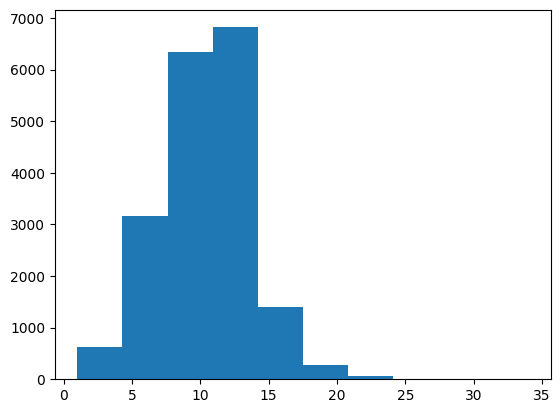

In [ ]:
sequence_lengths = []

for i in range(len(X_train)):
  sequence_lengths.append(len(X_train[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)

In [ ]:
pd.Series(sequence_lengths).describe()

count    18696.000000
mean        10.231226
std          3.284018
min          1.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         34.000000
dtype: float64

In [ ]:
print(X_train[0].shape)

(12, 50)


In [ ]:
print(X_train[1].shape)

(4, 50)


In [ ]:
print(X_train[3].shape)

(7, 50)


In [ ]:
from copy import deepcopy

def pad_X(X, desired_sequence_length=57):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len

    pad = np.zeros(shape=(sequence_length_difference, 50))

    X_copy[i] = np.concatenate([x, pad])

  return np.array(X_copy).astype(float)

In [ ]:
X_train = pad_X(X_train)

X_train.shape

(18696, 57, 50)

In [ ]:
y_train.shape

(18696,)

In [ ]:
print(X_train[0].shape)

(57, 50)


In [ ]:
print(X_train[1].shape)

(57, 50)


In [ ]:
print(X_train[3].shape)

(57, 50)


In [ ]:
X_val, y_val = df_to_X_y(val_df)
X_val = pad_X(X_val)

X_val.shape, y_val.shape

((4006, 57, 50), (4006,))

In [ ]:
X_test, y_test = df_to_X_y(test_df)
X_test = pad_X(X_test)

X_test.shape, y_test.shape

((4007, 57, 50), (4007,))

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([])

model.add(layers.Input(shape=(57, 50)))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 57, 64)            29440     
                                                                 
 dropout_3 (Dropout)         (None, 57, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 57, 64)            33024     
                                                                 
 dropout_4 (Dropout)         (None, 57, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 57, 64)            33024     
                                                                 
 dropout_5 (Dropout)         (None, 57, 64)            0         
                                                                 
 flatten_1 (Flatten)         (None, 3648)             

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint('model/', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', AUC(name='auc')])

In [ ]:
# Weight Matrix

In [ ]:
frequencies = pd.value_counts(df['is_sarcastic'])

frequencies

is_sarcastic
0    14985
1    11724
Name: count, dtype: int64

In [ ]:
weights = {0: frequencies.sum() / frequencies[0], 1: frequencies.sum() / frequencies[1]}
weights

{0: 1.7823823823823823, 1: 2.278147389969294}

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp], class_weight=weights)

Epoch 1/20
585/585 [==============================] - 9s 12ms/step - loss: 0.1844 - accuracy: 0.9638 - auc: 0.9944 - val_loss: 0.6079 - val_accuracy: 0.8397 - val_auc: 0.9030
Epoch 2/20
585/585 [==============================] - 10s 18ms/step - loss: 0.1186 - accuracy: 0.9783 - auc: 0.9973 - val_loss: 0.7894 - val_accuracy: 0.8352 - val_auc: 0.8966
Epoch 3/20
585/585 [==============================] - 9s 15ms/step - loss: 0.0928 - accuracy: 0.9835 - auc: 0.9984 - val_loss: 0.9487 - val_accuracy: 0.8395 - val_auc: 0.8887
Epoch 4/20
585/585 [==============================] - 7s 12ms/step - loss: 0.0909 - accuracy: 0.9841 - auc: 0.9983 - val_loss: 0.8858 - val_accuracy: 0.8305 - val_auc: 0.8918
Epoch 5/20
585/585 [==============================] - 11s 18ms/step - loss: 0.0730 - accuracy: 0.9857 - auc: 0.9990 - val_loss: 0.9336 - val_accuracy: 0.8335 - val_auc: 0.8864
Epoch 6/20
585/585 [==============================] - 8s 14ms/step - loss: 0.0711 - accuracy: 0.9877 - auc: 0.9988 - val_lo

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('model/')

In [ ]:
test_predictions = (best_model.predict(X_test) > 0.5).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_test, test_predictions))

126/126 [==============================] - 4s 7ms/step
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2230
           1       0.85      0.78      0.81      1777

    accuracy                           0.84      4007
   macro avg       0.84      0.83      0.84      4007
weighted avg       0.84      0.84      0.84      4007



In [ ]:
all_words = " ".join([sentence for sentence in df['headline']])

from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height=500, random_state=42, max_font_size=100).generate(all_words)

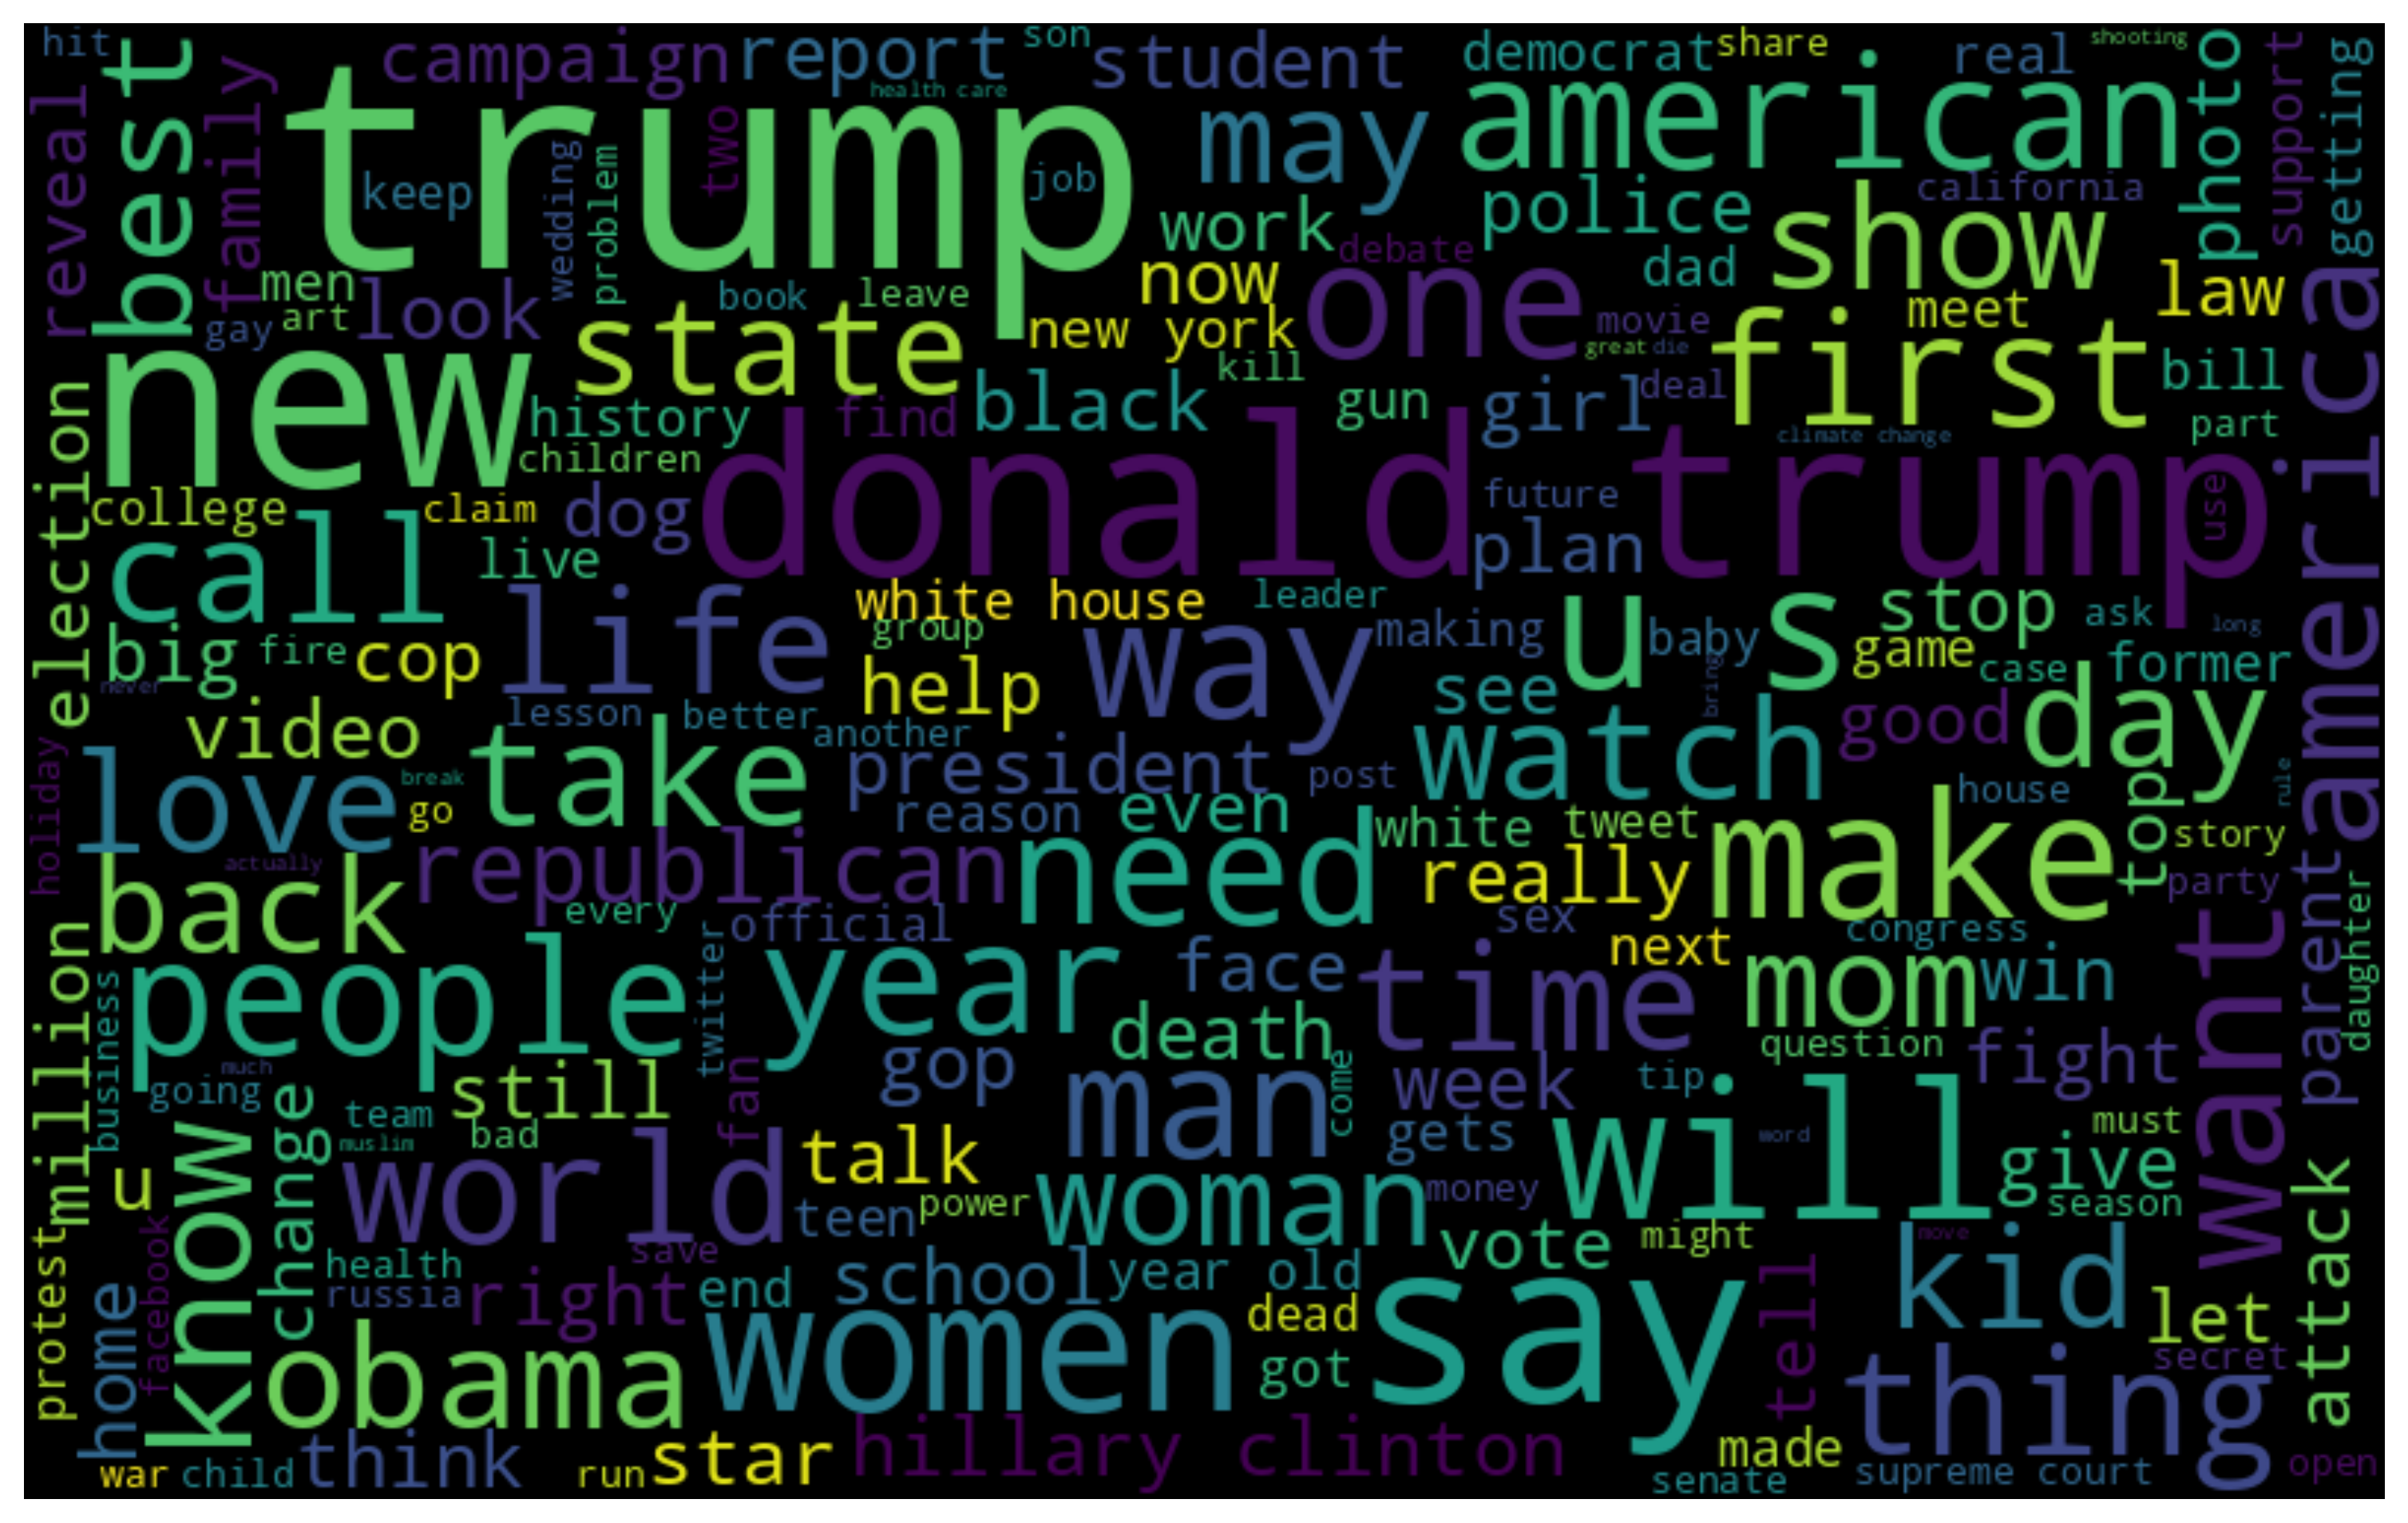

In [ ]:
plt.figure(figsize=(15,8), dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

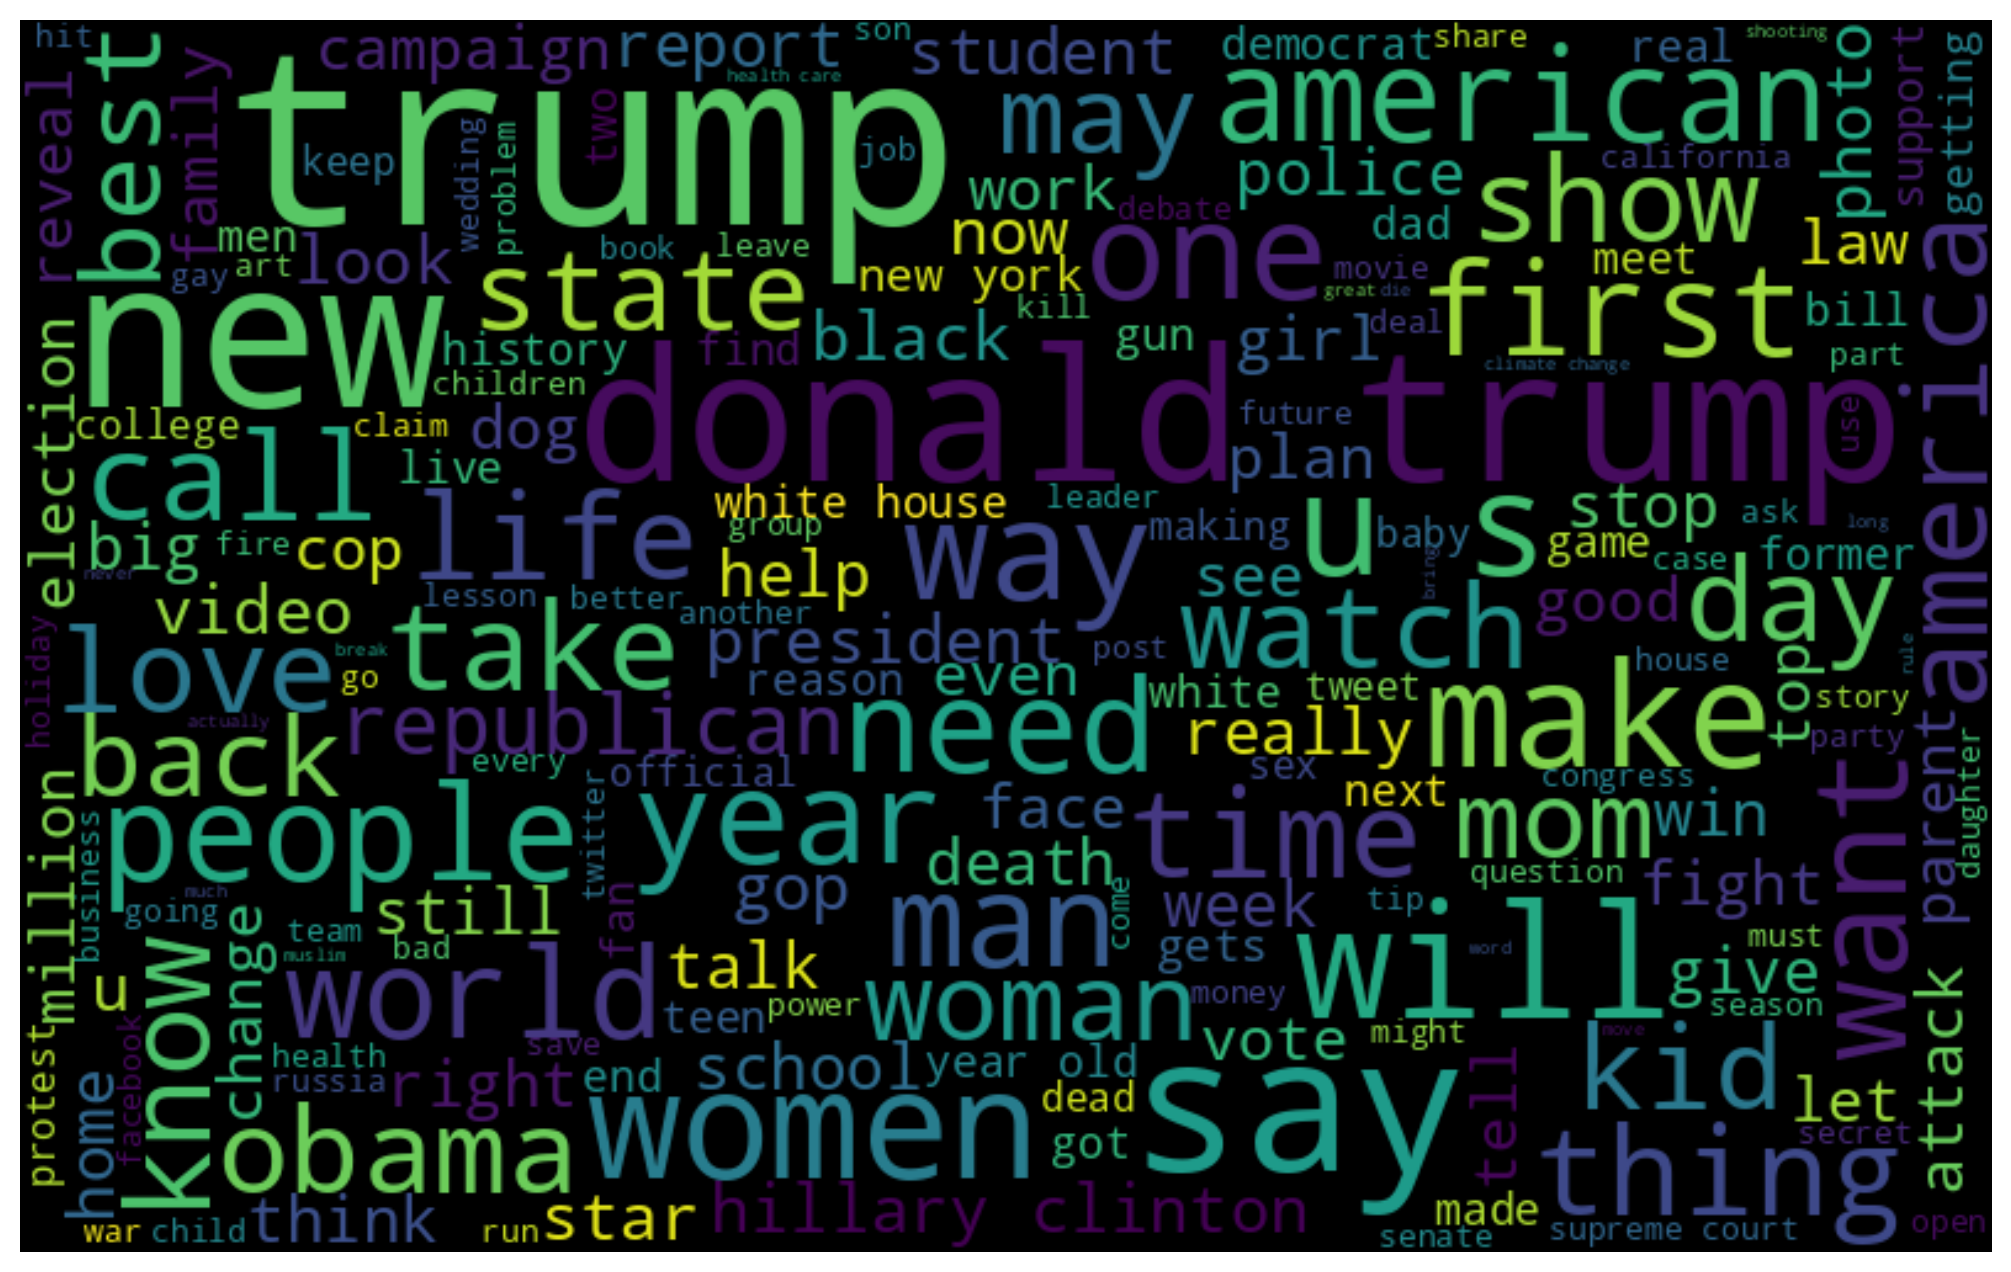

In [ ]:
# frequent postive words

all_words = " ".join([sentence for sentence in df['headline'][df['is_sarcastic']==0]])

from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height=500, random_state=42, max_font_size=100).generate(all_words)
plt.figure(figsize=(15,8), dpi=200)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

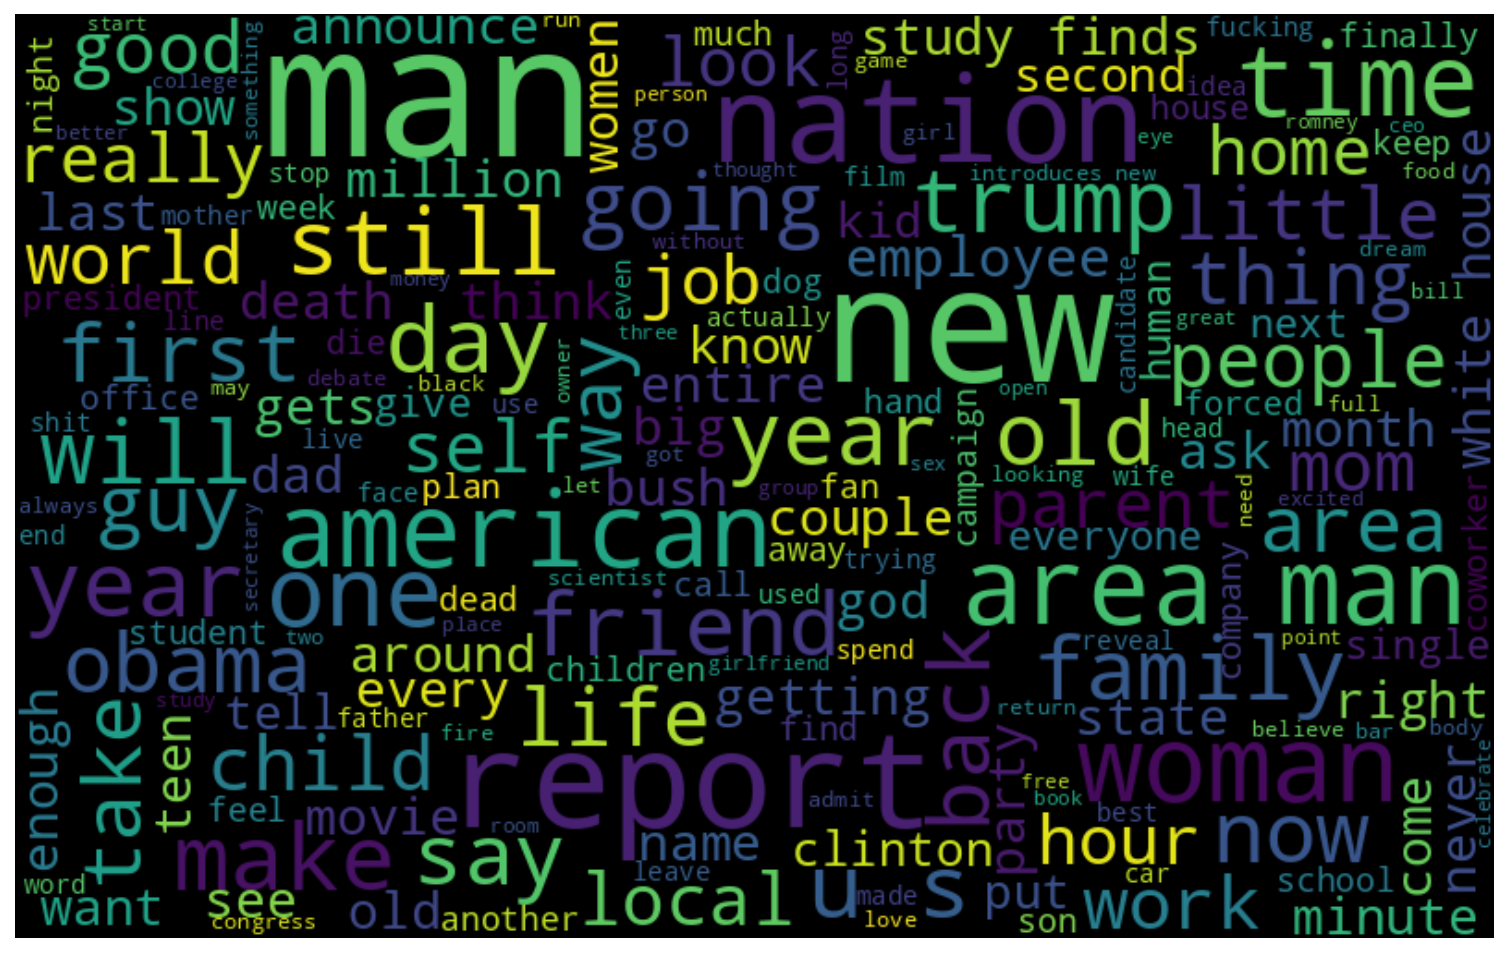

In [ ]:
# frequent negative words

all_words = " ".join([sentence for sentence in df['headline'][df['is_sarcastic']==1]])

from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height=500, random_state=42, max_font_size=100).generate(all_words)
plt.figure(figsize=(15,8), dpi=150)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()